In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn import metrics, svm, neural_network, ensemble
from datetime import datetime, timedelta
import hydroeval

In [33]:
dir = 'ObservedDischarge_LBRM_2011-2014'  # Read runoff observations
data_runoff = pd.DataFrame(columns=['date','runoff', 'lake', 'subbasin'])
for f in os.listdir(dir):
    data = pd.read_fwf(os.path.join(dir, f), widths=[8,11], skiprows=2, index_col=False, header=None, names=['date', 'runoff'], na_values='-0.9999E+09')
    data['date'] = data['date'].str.replace(' ', '0').str.pad(8, 'left', '0').apply(lambda d: pd.to_datetime(d, format='%d%m%Y'))
    data['lake'] = f[:3]
    data['subbasin'] = int(f[3:5])
    data_runoff = data_runoff.append(data, ignore_index=True)

In [34]:
# Additionally read 2010 observation data
dir_2010 = 'ObservedDischarge_LBRM_2010'
data_runoff_2010 = pd.DataFrame(columns=['date','runoff', 'lake', 'subbasin'])
for f in os.listdir(dir_2010):
    data_2010 = pd.read_fwf(os.path.join(dir_2010, f), widths=[8,11], skiprows=2, index_col=False, header=None, names=['date', 'runoff'], na_values='-0.9999E+09')
    data_2010['date'] = data_2010['date'].astype(str).str.replace(' ', '0').str.pad(8, 'left', '0').apply(lambda d: pd.to_datetime(d, format='%d%m%Y'))
    data_2010['lake'] = f[:3]
    data_2010['subbasin'] = int(f[3:5])
    data_runoff_2010 = data_runoff_2010.append(data_2010, ignore_index=True)

In [35]:
data_runoff = data_runoff_2010.append(data_runoff, ignore_index=True)

In [36]:
dir = 'RDRS_daily_LBRM'  # Read independent variables
data_forcing = pd.DataFrame(columns=['date', 'tmin', 'tmax', 'prec', 'lake', 'subbasin'])
for f in os.listdir(dir):
    data = pd.read_csv(os.path.join(dir, f), sep=',', skiprows=3, index_col=False, header=None, names=['date', 'tmin', 'tmax', 'prec'])
    data['date'] = data['date'].apply(lambda d: pd.to_datetime(d, format='%Y-%m-%d'))
    data['lake'] = f[9:12]
    data['subbasin'] = int(f[12:14])
    data_forcing = data_forcing.append(data, ignore_index=True)

In [37]:
data = pd.merge(data_forcing, data_runoff, on=['lake', 'subbasin', 'date'], how='outer')

In [38]:
data_with_runoff = data[(data['date'] < '2015-01-01')]
data_with_runoff[pd.isna(data_with_runoff['runoff'])].groupby(['lake', 'subbasin'])['date'].count()  # Count NAs per subbasin

lake  subbasin
eri   3           1826
      12           519
      14          1826
      18          1826
stc   2           1826
      4           1826
Name: date, dtype: int64

In [39]:
data_with_runoff = data_with_runoff[~pd.isna(data_with_runoff['runoff'])].reset_index(drop=True)

#### First try: just for one lake

In [40]:
history = 8  # How many days of history to include as independent variables
use_runoff_history = False  # Whether to use runoff history as independent variable

eri6 = data_with_runoff[(data_with_runoff['lake'] == 'eri') & (data_with_runoff['subbasin'] == 6)].drop(['lake', 'subbasin'], axis=1).set_index('date')
eri6_with_history = eri6.copy()
for i in range(1, history + 1):  # Add history columns of day i
    if use_runoff_history:
        eri6_with_history[['-{}_tmin'.format(i), '-{}_tmax'.format(i), '-{}_prec'.format(i), '-{}_runoff'.format(i)]] = eri6.shift(i, axis=0)
    else:
        eri6_with_history[['-{}_tmin'.format(i), '-{}_tmax'.format(i), '-{}_prec'.format(i)]] = eri6.drop('runoff',axis=1).shift(i, axis=0)
eri6_with_history.head()

,tmin,tmax,prec,runoff,-1_tmin,-1_tmax,-1_prec,-2_tmin,-2_tmax,-2_prec,...,-5_prec,-6_tmin,-6_tmax,-6_prec,-7_tmin,-7_tmax,-7_prec,-8_tmin,-8_tmax,-8_prec
date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,-9.2961,-5.6233,0.4428,0.068969,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-02,-13.3759,-7.7081,0.6701,0.056728,-9.2961,-5.6233,0.4428,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-03,-18.4453,-7.6125,0.0815,0.051503,-13.3759,-7.7081,0.6701,-9.2961,-5.6233,0.4428,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,-7.8749,-5.7792,2.0898,0.028812,-18.4453,-7.6125,0.0815,-13.3759,-7.7081,0.6701,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,-7.6568,-4.1856,1.1104,0.017018,-7.8749,-5.7792,2.0898,-18.4453,-7.6125,0.0815,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
# train_start is first day without NAs in history (i.e. day no. `history + 1`)
train_start = datetime.strptime('2010-01-01', '%Y-%m-%d') + timedelta(days=history + 1)

train = eri6_with_history.loc[train_start : '2012-12-31']
test = eri6_with_history.loc['2013-01-01' : '2013-12-31']
m = linear_model.LinearRegression()
m.fit(train.drop('runoff', axis=1), train['runoff'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [42]:
predict = pd.DataFrame(columns=test.columns, index=test.index)
predict.loc[:,['tmin', 'tmax', 'prec']] = test[['tmin', 'tmax', 'prec']]
for i in range(history):
    # Get independent variable history
    predict.loc[:,['-{}_tmin'.format(i + 1), '-{}_tmax'.format(i + 1), '-{}_prec'.format(i + 1)]] = \
        test[['-{}_tmin'.format(i + 1), '-{}_tmax'.format(i + 1), '-{}_prec'.format(i + 1)]]
    # Get dependent variable history
    if use_runoff_history:
        for j in range(i + 1, history + 1):
            predict.iloc[i]['-{}_runoff'.format(j)] = test.iloc[i]['-{}_runoff'.format(j)]
for i in range(len(predict)):
    predict.iloc[i]['runoff'] = m.predict([predict.iloc[i].drop('runoff')])[0]  # Predict for day i
    if use_runoff_history:  # Append prediction to next days' dependent variable histories
        for j in range(1, history + 1):
            if (i + j) >= len(predict):
                break
            predict.iloc[i + j]['-{}_runoff'.format(j)] = predict.iloc[i]['runoff']

In [43]:
mse = metrics.mean_squared_error(test['runoff'], predict['runoff'])

predict_clipped = predict.copy()
predict_clipped['runoff'] = predict['runoff'].clip(0)  # Runoff < 0 doesn't make sense
mse_clip = metrics.mean_squared_error(test['runoff'], predict_clipped['runoff'])

print('RMSE (raw):', np.sqrt(mse), 'RMSE (clipped to 0):', np.sqrt(mse_clip))
print('NSE: (clipped to 0)', hydroeval.evaluator(hydroeval.nse, predict_clipped['runoff'].to_numpy(), test['runoff'].to_numpy()))

RMSE (raw): 0.08167596252943521 RMSE (clipped to 0): 0.07796763303230046
NSE: (clipped to 0) [0.71761252]


#### Second step: predict for all subbasins

In [54]:
# Create test and train splits for each subbasin (by time)
train_start = datetime.strptime('2010-01-01', '%Y-%m-%d') + timedelta(days=history + 1)
use_runoff_history = False

train_all = None
test_all = None
for lake in data_with_runoff['lake'].unique():
    for subbasin in data_with_runoff[data_with_runoff['lake'] == lake]['subbasin'].unique():
        subbasin_data = data_with_runoff[(data_with_runoff['lake'] == lake) & (data_with_runoff['subbasin'] == subbasin)].set_index('date')
        
        for i in range(1, history + 1):
            if use_runoff_history:
                subbasin_data[['-{}_tmin'.format(i), '-{}_tmax'.format(i), '-{}_prec'.format(i), '-{}_runoff'.format(i)]] = subbasin_data[['tmin','tmax','prec', 'runoff']].shift(i, axis=0)
            else:
                subbasin_data[['-{}_tmin'.format(i), '-{}_tmax'.format(i), '-{}_prec'.format(i)]] = subbasin_data[['tmin','tmax','prec']].shift(i, axis=0)

        subbasin_train = subbasin_data.loc[train_start : '2012-12-31']
        subbasin_test = subbasin_data.loc['2013-01-01' : '2013-12-31']
        
        if train_all is None:
            train_all = subbasin_train.reset_index()
            test_all = subbasin_test.reset_index()
        else:
            train_all = train_all.append(subbasin_train.reset_index(), ignore_index=True)
            test_all = test_all.append(subbasin_test.reset_index(), ignore_index=True)

In [55]:
# Create predictions for each subbasin
predictions = {}
actuals = {}
for lake in data_with_runoff['lake'].unique():
    for subbasin in data_with_runoff[data_with_runoff['lake'] == lake]['subbasin'].unique():
        
        train_subbasin = train_all[(train_all['lake'] == lake) & (train_all['subbasin'] == subbasin)].set_index('date')
        m.fit(train_subbasin.drop(['lake', 'subbasin', 'runoff'], axis=1), train_subbasin['runoff'])
        
        test_subbasin = test_all[(test_all['lake'] == lake) & (test_all['subbasin'] == subbasin)].set_index('date')
        test_subbasin = test_subbasin[~pd.isna(test_subbasin['runoff'])]
        if len(test_subbasin) == 0:
            print('Skipping', lake, subbasin)
            continue
        predict = pd.DataFrame(columns=[x for x in test_subbasin.columns if x not in ['lake', 'subbasin']], index=test_subbasin.index)
        predict.loc[:,['tmin', 'tmax', 'prec']] = test_subbasin[['tmin', 'tmax', 'prec']]
        for i in range(history):
            predict.loc[:,['-{}_tmin'.format(i + 1), '-{}_tmax'.format(i + 1), '-{}_prec'.format(i + 1)]] = \
                test_subbasin[['-{}_tmin'.format(i + 1), '-{}_tmax'.format(i + 1), '-{}_prec'.format(i + 1)]]
            if use_runoff_history:
                for j in range(i + 1, history + 1):
                    predict.iloc[i]['-{}_runoff'.format(j)] = test_subbasin.iloc[i]['-{}_runoff'.format(j)]
        for i in range(len(predict)):
            predict.iloc[i]['runoff'] = m.predict([predict.iloc[i].drop('runoff')])[0]
            if use_runoff_history:
                for j in range(1, history + 1):
                    if (i + j) >= len(predict):
                        break
                    predict.iloc[i + j]['-{}_runoff'.format(j)] = predict.iloc[i]['runoff']
        predictions[lake + str(subbasin)] = predict
        actuals[lake + str(subbasin)] = test_subbasin['runoff']

Skipping eri 12


eri1 
	RMSE (clipped to 0): 0.06154206032545033
	NSE: (clipped to 0) 0.6667811811130236
eri2 
	RMSE (clipped to 0): 0.03674313811804403
	NSE: (clipped to 0) 0.22319315777959015
eri4 
	RMSE (clipped to 0): 0.06887299603210388
	NSE: (clipped to 0) 0.12178178602593015
eri5 
	RMSE (clipped to 0): 0.09674426283060428
	NSE: (clipped to 0) 0.25344035445132296
eri6 
	RMSE (clipped to 0): 0.07796763303230046
	NSE: (clipped to 0) 0.7176125164291212
eri7 
	RMSE (clipped to 0): 0.15047012382116026
	NSE: (clipped to 0) 0.7279602306688894
eri8 
	RMSE (clipped to 0): 0.1438983079165736
	NSE: (clipped to 0) 0.7306643533304036
eri9 
	RMSE (clipped to 0): 0.19961377593732318
	NSE: (clipped to 0) 0.6027148747642435
eri10 
	RMSE (clipped to 0): 0.1729269853972601
	NSE: (clipped to 0) 0.623502854753617
eri11 
	RMSE (clipped to 0): 0.08570840894722531
	NSE: (clipped to 0) 0.5931088151245543
eri13 
	RMSE (clipped to 0): 0.1347629217239711
	NSE: (clipped to 0) 0.5553787364083612
eri15 
	RMSE (clipped to 0): 0

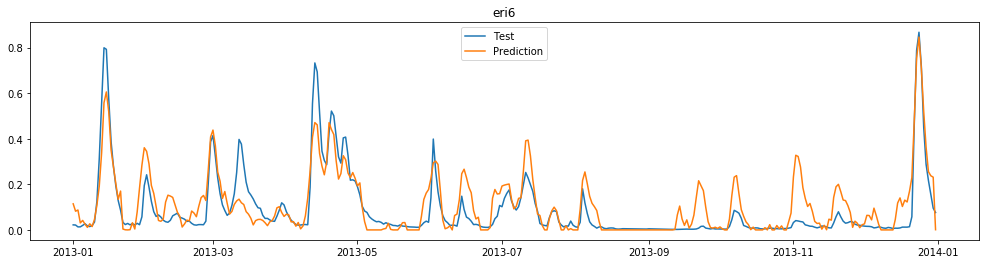

In [56]:
# Evaluate each subbasin
nse_list = []
plot_list = ['eri6']
for subbasin, predict in predictions.items():
    mse = metrics.mean_squared_error(actuals[subbasin], predict['runoff'])

    predict_clipped = predict.copy()
    predict_clipped['runoff'] = predict['runoff'].clip(0)
    mse_clip = metrics.mean_squared_error(actuals[subbasin], predict_clipped['runoff'])
    nse_list.append(hydroeval.evaluator(hydroeval.nse, predict_clipped['runoff'].to_numpy(), actuals[subbasin].to_numpy())[0])
    
    print(subbasin, '\n\tRMSE (clipped to 0):', np.sqrt(mse_clip))
    print('\tNSE: (clipped to 0)', nse_list[-1])
    
    if subbasin in plot_list:
        plt.figure(figsize=(17,4))
        plt.title(subbasin)
        plt.plot(actuals[subbasin], label='Test')
        plt.plot(predict_clipped['runoff'], label='Prediction')
        plt.legend()
print('Median NSE (clipped to 0)', np.median(nse_list))